## Feed forward NN

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

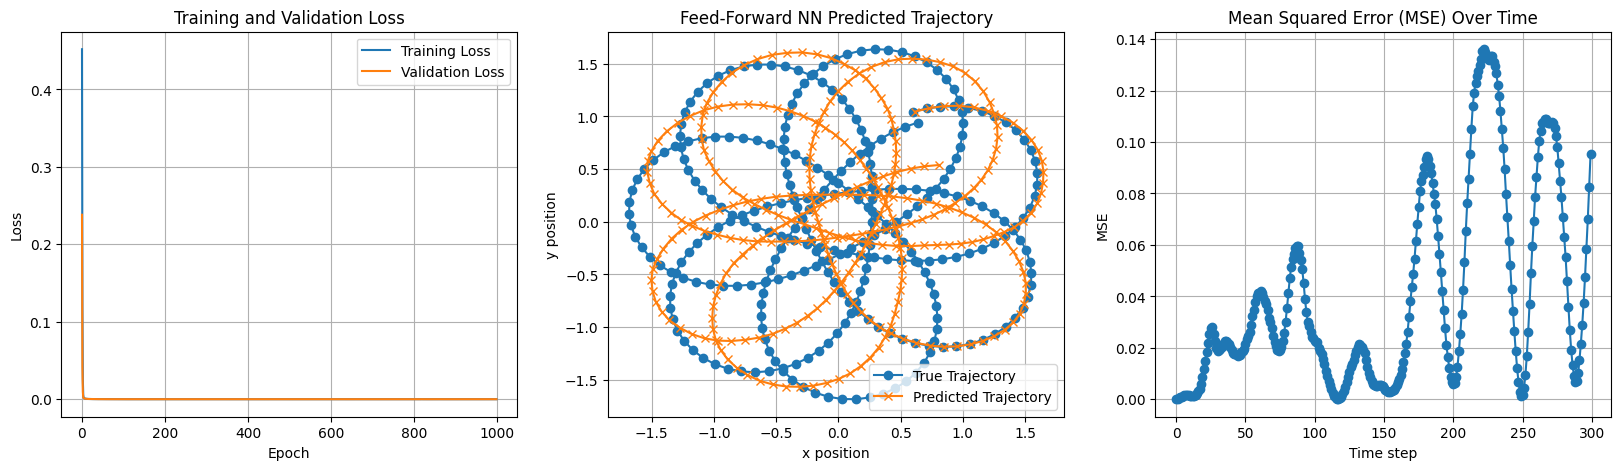

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model
from plotting import extract_initial_state_and_true_positions, plot_predicted_trajectories

batch_size = 64
num_epochs = 1000
seq_length = 1  # Single step sequence

# initialize figures for plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, test_loader, criterion, optimizer, ax1, num_epochs)
evaluate_model(model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)


# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'Feed-Forward NN Predicted Trajectory', axisPlt=ax2)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - np.array(predicted_positions)) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

ax3.plot(mse, marker='o')
ax3.set_title('Mean Squared Error (MSE) Over Time')
ax3.set_xlabel('Time step')
ax3.set_ylabel('MSE')
ax3.grid(True)
plt.show()


## Recurrent NN

Epoch 100/100, Loss: 0.0001: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


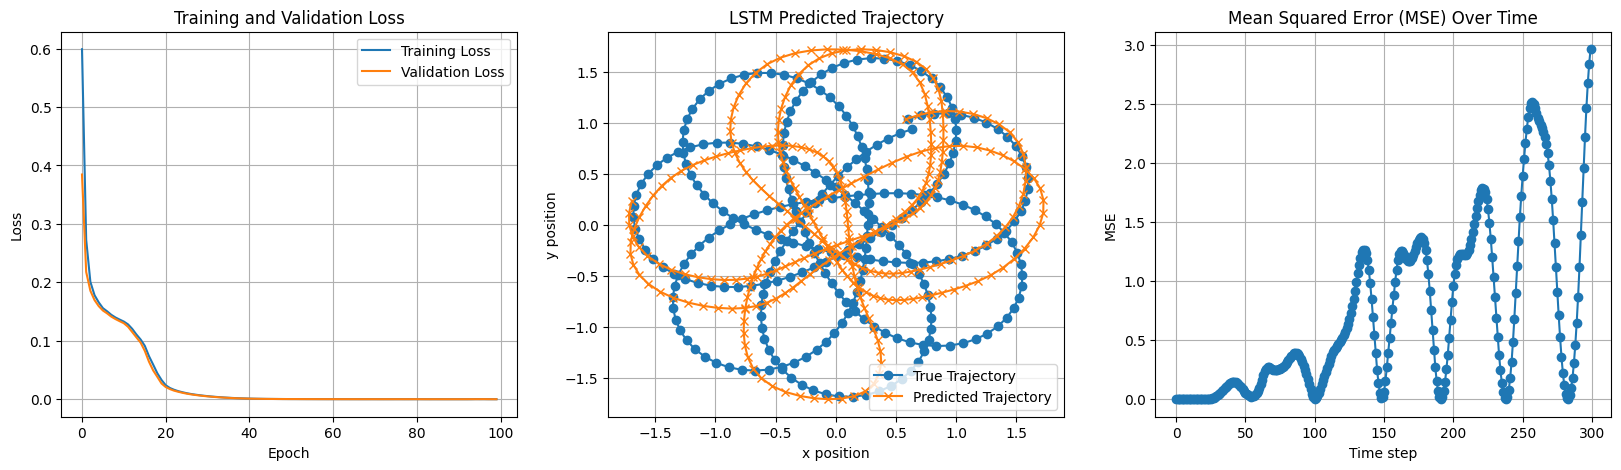

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders_LSTM
from src.network import RecurrentNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
from plotting import extract_initial_state_and_true_positions_LSTM, plot_predicted_trajectories_LSTM

batch_size = 64
num_epochs = 100
seq_length = 16  # Single step sequence

# initialize figures for plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Get dataloaders
train_loader, test_loader = get_dataloaders_LSTM(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the LSTM model, define loss function and optimizer
rnn_model = RecurrentNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the LSTM model
train_model(rnn_model, train_loader,test_loader, criterion, optimizer, ax1, num_epochs=num_epochs)
# Evaluate the LSTM model
evaluate_model(rnn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions_LSTM(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories_LSTM(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', ax2, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

ax3.plot(mse, marker='o')
ax3.set_title('Mean Squared Error (MSE) Over Time')
ax3.set_xlabel('Time step')
ax3.set_ylabel('MSE')
ax3.grid(True)
plt.show()



## Physics informed Feed Forward NN

Training standard NN


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250/250, Training Loss: 0.3984, Validation Loss: 0.2437: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]


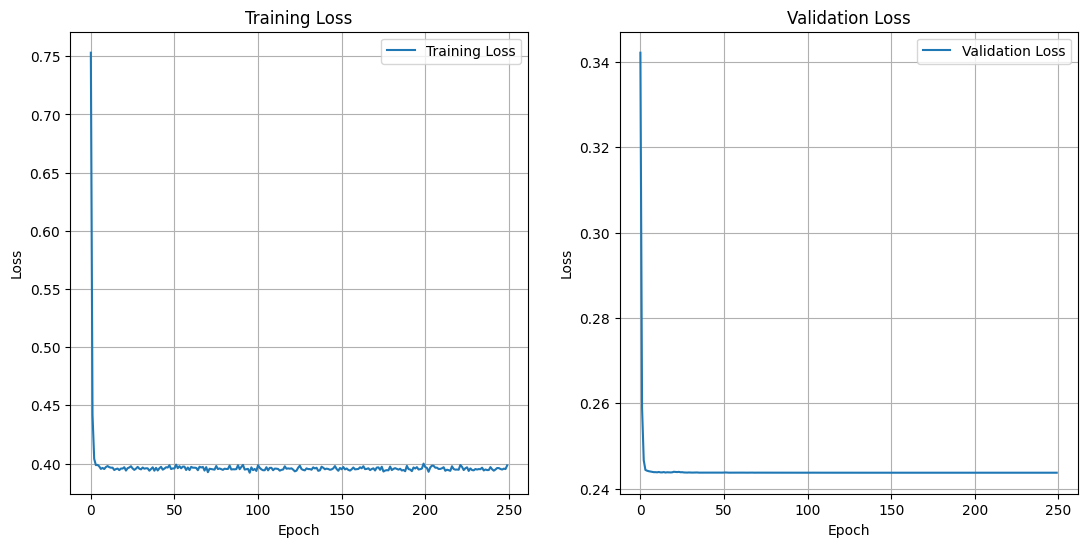

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
import torch.autograd as ag

epochs = 250 #1000
n_data = 300
batch_size=64

## ------------------ set up models-------------------------- ##
# set network size
n_in = 4 # 2 channels position and 2 channels velocity
n_h1 = 100
n_h2 = 50
n_o = 4 # 2 channels for position and 2 channels for velocity at next time step

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt")

# Define the physics-informed neural network
model = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o),
)


# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

criterion=nn.MSELoss()

def callculateStep(input_states):
    
    batch_size = input_states.size(0)
    x = input_states[:, 0:2]
    v = input_states[:, 2:4]

    q=1
    m=1
    
    B_x = torch.zeros(batch_size, 2)
    B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1,1)),1).view(-1,1,3)

    B_hat = torch.zeros((B_x.shape[0], 3, 3))
    
    B_hat[:,0,1] = - B_x[:,0,2]
    B_hat[:,0,2] = B_x[:,0,1]
    B_hat[:,1,2] = - B_x[:,0,0]
    
    B_hat[:,1,0] = B_x[:,0,2]
    B_hat[:,2,0] = - B_x[:,0,1]
    B_hat[:,2,1] = B_x[:,0,0]

    # H - magnetic field strength, phi electric potential
    # phi = 1/100/torch.sqrt(x[:,0]**2 + x[:,1]**2)
    # H = 1/2 * torch.einsum('ij,ij->i', v, v) * m + q * phi
    # calculate delta H
    
    deltaH = torch.zeros(batch_size, 6)
    deltaH[:,0] = m * v[:,0]
    deltaH[:,1] = m * v[:,1]

    deltaH[:,3] = - q * x[:,0]/100 / torch.sqrt(x[:,0]**2 + x[:,1]**2) **3
    deltaH[:,4] = - q * x[:,1]/100 / torch.sqrt(x[:,0]**2 + x[:,1]**2) **3

    vx_matrix = torch.zeros((batch_size, 6, 6))
    vx_matrix[:,0:3,0:3] = -q/m**2 * B_hat
    vx_matrix[:,0:3,3:6] = -1/m *torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3) 
    vx_matrix[:,3:6,0:3] = 1/m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)

    dvdx = torch.einsum('ijk,ik->ij',vx_matrix, deltaH)

    # dv = dvdx[:,0:3]
    # dx = dvdx[:,3:6]
    
    return dvdx  

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for input_states, output_states in train_loader:
        optimizer.zero_grad()
        
        x_train = input_states
        yhat = model(x_train)
        
        y_train = output_states

        dvdx = callculateStep(input_states)
        
        loss = criterion(y_train, yhat) + criterion(x_train+dvdx[:, [0,1,3,4] ], yhat)


        loss.backward()
        optimizer.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    for input_states, output_states in test_loader:
        with torch.no_grad():
            yhat = model(input_states)
            dvdx = callculateStep(input_states)
            loss = criterion(output_states, yhat)  + criterion(input_states+dvdx[:, [0,1,3,4] ], yhat)
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])


print('Training standard NN')

progress_bar = tqdm(range(epochs))    

for epoch in progress_bar:
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    progress_bar.set_description(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[epoch][0]:.4f}, Validation Loss: {val_loss[epoch][0]:.4f}')
    

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot training loss in the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss in the second subplot
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the figure
plt.show()


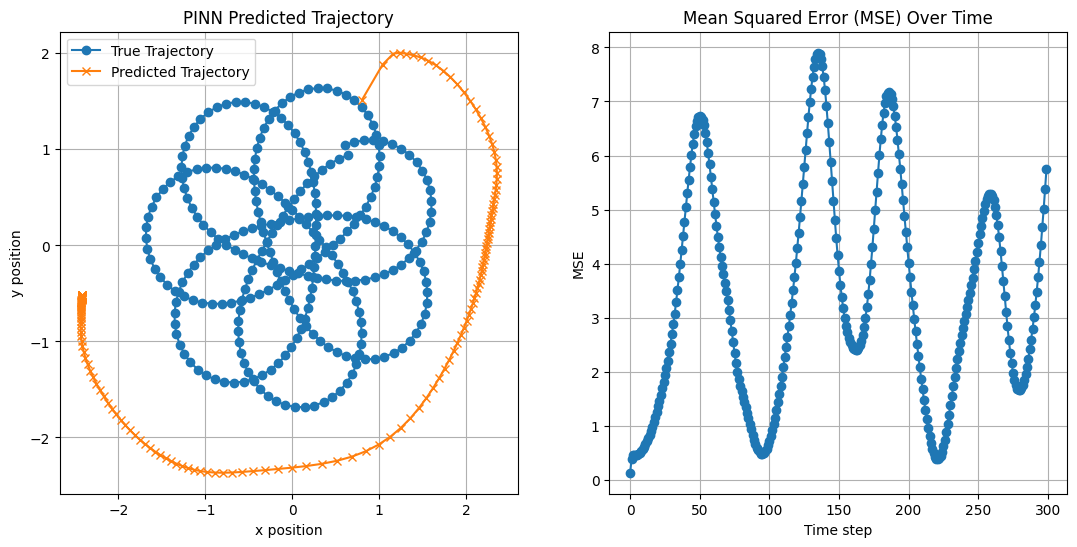

In [30]:
from plotting import plot_predicted_trajectories, extract_initial_state_and_true_positions

# initialize figures for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'PINN Predicted Trajectory', ax1, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = torch.mean((true_positions - torch.tensor(predicted_positions)) ** 2, axis=1)

ax2.plot(mse, marker='o')
ax2.set_title('Mean Squared Error (MSE) Over Time')
ax2.set_xlabel('Time step')
ax2.set_ylabel('MSE')
ax2.grid(True)
plt.show()

# it should be so bad, but try it for q and m


## Raj feedback


dont use rnn besause of eploding grdaient lstm, 

use simplictic NN

VPT - check in simpnet paper

Hamiltoninan system - no right deffinition of the long time

## Symplectic-Neural-Networks-(SympNet):-Pendulum-System

Training...
0        Train loss: 0.008960857923365434     Test loss: 0.008958109268352282     
1000     Train loss: 0.0009973716129678433    Test loss: 0.0009955958210678855    
2000     Train loss: 0.0009775666261854208    Test loss: 0.0009759939357841408    
3000     Train loss: 0.0009491325259948297    Test loss: 0.0009478147836116439    
4000     Train loss: 0.0009220980543967341    Test loss: 0.0009213973310187736    
5000     Train loss: 0.0008929111125740174    Test loss: 0.0008927125144316291    
6000     Train loss: 0.0008815535296599137    Test loss: 0.0008813740619354033    
7000     Train loss: 0.0008801404586964462    Test loss: 0.0008801240953259447    
8000     Train loss: 0.0008795219958053315    Test loss: 0.000879596954133378     
9000     Train loss: 0.0008788325840777225    Test loss: 0.0008790305786364184    
10000    Train loss: 0.0008782616125096195    Test loss: 0.0008784956576599833    
Done!
'run' took 30.677229404449463 s
Best model at iteration 10000:
Train 

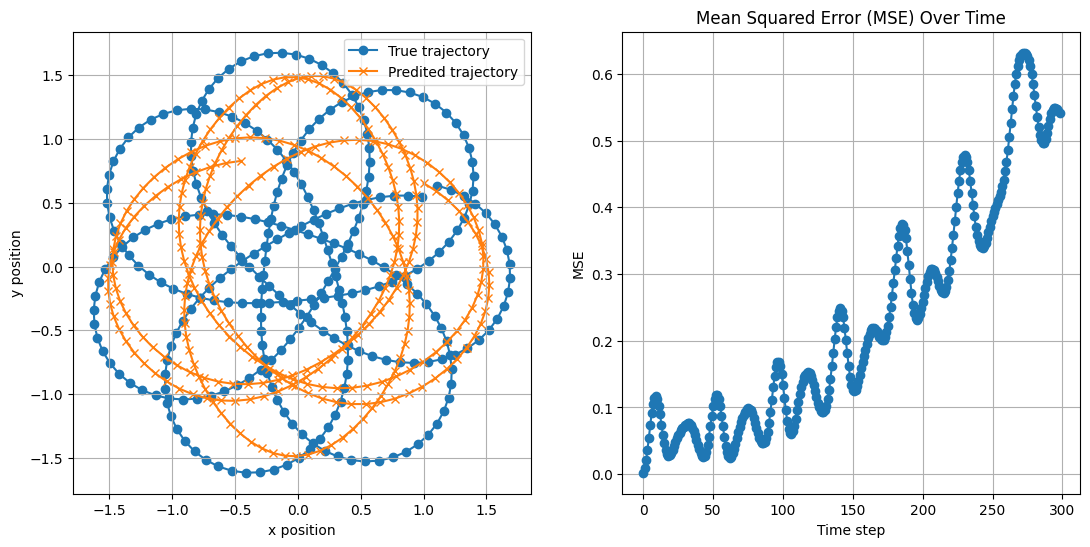

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import learner_SympNet as ln
from learner_SympNet.integrator.hamiltonian import SV

from src.dataset import get_data_SimpNet

DIM=4

class PDData(ln.Data):
    def __init__(self, x0, h, train_num, test_num, add_h=False):
        super(PDData, self).__init__()
        # self.dH = callculateStep
        # self.solver = SV(None, self.dH, iterations=1, order=6, N=10)
        # self.x0 = x0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.add_h = add_h
        self.__init_data()
        
    @property
    def dim(self):
        return DIM
    
    # def __generate_flow(self, x0, h, num):
    #     X = self.solver.flow(np.array(x0), h, num)
    #     x, y = X[:-1], X[1:]
    #     if self.add_h:
    #         x = np.hstack([x, self.h * np.ones([x.shape[0], 1])])
    #     return x, y
    
    def __init_data(self):
        train_input_sequences, train_output_sequences, _, _  = get_data_SimpNet("data_lorentz/train.txt", "data_lorentz/test.txt")
        
        self.X_train = train_input_sequences[:1200,:] 
        self.y_train = train_output_sequences[:1200,:]
        self.X_test = train_input_sequences[1200:,:] 
        self.y_test = train_output_sequences[1200:,:]
        
        if self.add_h:
            self.X_train = np.hstack([self.X_train, self.h * np.ones([self.X_train.shape[0], 1])])
            self.X_test = np.hstack([self.X_test, self.h * np.ones([self.X_test.shape[0], 1])])
        

def plot(data, net):
    steps = data.y_test.shape[0]
    if isinstance(net, ln.nn.HNN):
        flow_true = data.y_test
        # data.solver.flow(data.X_test_np[0][:-1], data.h, steps)
        flow_pred = net.predict(data.X_test[0, :-1], data.h, steps, keepinitx=True, returnnp=True)
        # flow_pred = net.predict(data.X_test[0][:-1], data.h, steps, keepinitx=True, returnnp=True)
    else:
        flow_true = data.y_test
        # data.solver.flow(data.X_test_np[0], data.h, steps)
        flow_pred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    
    # initialize figures for plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    
    ax1.plot(flow_true[:, 2], flow_true[:, 3], marker='o', label='True trajectory', zorder=0)
    ax1.plot(flow_pred[:, 2], flow_pred[:, 3], marker='x',  label='Predited trajectory', zorder=1)
    # plt.scatter(data.X_train_np[:, 0], data.X_train_np[:, 1], color='b', label='Learned data', zorder=2)
    ax1.grid(True)
    ax1.set_xlabel("x position")
    ax1.set_ylabel("y position")
    ax1.legend()

    mse = torch.mean((flow_true - torch.tensor(flow_pred[1:])) ** 2, axis=1)

    ax2.plot(mse, marker='o')
    ax2.set_title('Mean Squared Error (MSE) Over Time')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('MSE')
    ax2.grid(True)
    plt.show()

    


def main():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    x0 = [0, 1]
    h = 3
    train_num = 1200
    test_num = 300
    # net
    net_type = 'LA' # 'LA' or 'G' or 'HNN'
    LAlayers = 3
    LAsublayers = 2
    Glayers = 5
    Gwidth = 30
    activation = 'sigmoid'
    Hlayers = 4
    Hwidth = 30
    Hactivation = 'tanh'
    # training
    lr = 0.001
    iterations = 10000 #50000
    print_every = 1000
    
    add_h = True if net_type == 'HNN' else False
    criterion = None if net_type == 'HNN' else 'MSE'
    data = PDData(x0, h, train_num, test_num, add_h)
    if net_type == 'LA':
        net = ln.nn.LASympNet(data.dim, LAlayers, LAsublayers, activation)
    elif net_type == 'G':
        net = ln.nn.GSympNet(data.dim, Glayers, Gwidth, activation)
    elif net_type == 'HNN':
        net = ln.nn.HNN(data.dim, Hlayers, Hwidth, Hactivation)
    args = {
        'data': data,
        'net': net,
        'criterion': criterion,
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'double',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    plot(data, ln.Brain.Best_model())
    
if __name__ == '__main__':
    main()

## Poisson neural network

Training...
0        Train loss: 0.00734350923448801      Test loss: 0.007343700621277094     
1000     Train loss: 0.0005310963606461883    Test loss: 0.0005339986528269947    
2000     Train loss: 0.00023673429677728564   Test loss: 0.00024605754879303277   
3000     Train loss: 0.0001851960550993681    Test loss: 0.00019456364680081606   
4000     Train loss: 0.00015867158072069287   Test loss: 0.0001637676905374974    
5000     Train loss: 0.00017277208098676056   Test loss: 0.00017564609879627824   
6000     Train loss: 0.00013349395885597914   Test loss: 0.00013456822489388287   
7000     Train loss: 0.00011526197340572253   Test loss: 0.00011575342796277255   
8000     Train loss: 9.732408216223121e-05    Test loss: 9.790463809622452e-05    
9000     Train loss: 8.459057426080108e-05    Test loss: 8.579980203649029e-05    
10000    Train loss: 7.435275620082393e-05    Test loss: 7.522613304900005e-05    
Done!
'run' took 192.75701928138733 s
Best model at iteration 10000:
Train 

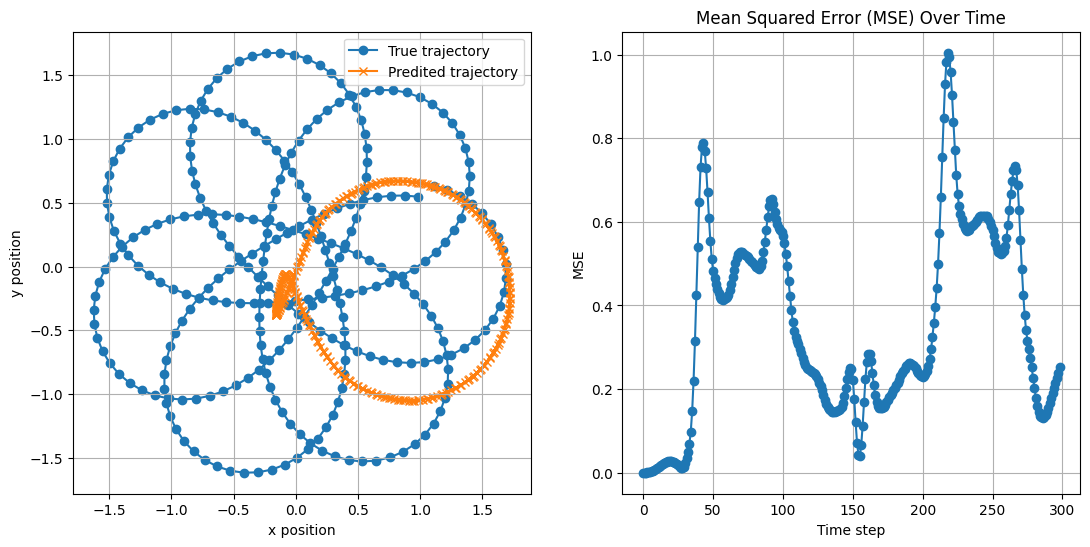

In [2]:
"""
@author: jpzxshi
"""
import numpy as np
import learner_pnn as ln
# FIXME:
# from data import LVData, PDData, LFData, ALData, TBData
from src.postprocess import LV_plot, PD_plot, LF_plot, AL_plot, TB_plot
from src.dataset import get_data_SimpNet

DIM = 4

class PDData(ln.Data):
    def __init__(self, x0, h, train_num, test_num, add_h=False):
        super(PDData, self).__init__()
        # self.dH = callculateStep
        # self.solver = SV(None, self.dH, iterations=1, order=6, N=10)
        # self.x0 = x0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.add_h = add_h
        self.__init_data()
        
    @property
    def dim(self):
        return DIM
    @property
    def latent_dim(self):
        return 2
    # def __generate_flow(self, x0, h, num):
    #     X = self.solver.flow(np.array(x0), h, num)
    #     x, y = X[:-1], X[1:]
    #     if self.add_h:
    #         x = np.hstack([x, self.h * np.ones([x.shape[0], 1])])
    #     return x, y
    
    def __init_data(self):
        train_input_sequences, train_output_sequences, _, _  = get_data_SimpNet("data_lorentz/train.txt", "data_lorentz/test.txt")
        
        self.X_train = train_input_sequences[:1200,:] 
        self.y_train = train_output_sequences[:1200,:]
        self.X_test = train_input_sequences[1200:,:] 
        self.y_test = train_output_sequences[1200:,:]
        
        if self.add_h:
            self.X_train = np.hstack([self.X_train, self.h * np.ones([self.X_train.shape[0], 1])])
            self.X_test = np.hstack([self.X_test, self.h * np.ones([self.X_test.shape[0], 1])])

def LV():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    z0 = [[1, 0.8], [1, 1], [1, 1.2]]
    h = 0.1
    train_num = 100
    test_num = 100
    # PNN
    inn_volume_preserving = False
    inn_layers = 3
    inn_sublayers = 2
    inn_subwidth = 30
    inn_activation = 'sigmoid'
    symp_type = 'G' # 'LA' or 'G'
    symp_LAlayers = 3
    symp_LAsublayers = 2
    symp_Glayers = 3
    symp_Gwidth = 30
    symp_activation = 'sigmoid'
    # training
    lr = 0.001
    iterations = 200000
    print_every = 1000
    
    data = LVData(z0, h, train_num, test_num)
    inn = ln.nn.INN(data.dim, data.dim // 2, inn_layers, inn_sublayers, inn_subwidth, inn_activation, 
                    volume_preserving=inn_volume_preserving)
    if symp_type == 'LA':
        sympnet = ln.nn.LASympNet(data.dim, symp_LAlayers, symp_LAsublayers, symp_activation)
    elif symp_type == 'G':
        sympnet = ln.nn.GSympNet(data.dim, symp_Glayers, symp_Gwidth, symp_activation)
    net = ln.nn.PNN(inn, sympnet)
    args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    LV_plot(data, ln.Brain.Best_model())
    
def PD():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    z0 = [[0, 1, 0 + 1 ** 2 + 0.0], 
          [0, 1.5, 0 + 1.5 ** 2 + 0.1],
          [0, 2, 0 + 2 ** 2 + 0.2]]
    h = 0.1
    train_num = 100
    test_num = 100
    # PNN
    inn_volume_preserving = False
    inn_layers = 3
    inn_sublayers = 2
    inn_subwidth = 30
    inn_activation = 'sigmoid'
    #symp_type = 'E' # should be 'E' in this case
    symp_Elayers = 3
    symp_Ewidth = 30
    symp_activation = 'sigmoid'
    # training
    lr = 0.001
    iterations =100000
    iterations =10000
    print_every = 1000
    
    data = PDData(z0, h, train_num, test_num)
    inn = ln.nn.INN(data.dim, data.latent_dim, inn_layers, inn_sublayers, inn_subwidth, inn_activation, 
                    volume_preserving=inn_volume_preserving)
    sympnet = ln.nn.ESympNet(data.dim, data.latent_dim, symp_Elayers, symp_Ewidth, symp_activation)
    net = ln.nn.PNN(inn, sympnet)
    args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    PD_plot(data, ln.Brain.Best_model())
    
def LF():
    device = 'gpu' # 'cpu' or 'gpu'
    # data
    z0 = [1, 0.5, 0.5, 1]
    h = 0.1
    train_num = 1500
    test_num = 300
    # PNN
    inn_volume_preserving = True
    inn_layers = 10
    inn_sublayers = 3
    inn_subwidth = 50
    inn_activation = 'sigmoid'
    symp_type = 'G' # 'LA' or 'G'
    symp_LAlayers = 3
    symp_LAsublayers = 2
    symp_Glayers = 10
    symp_Gwidth = 50
    symp_activation = 'sigmoid'
    # training
    lr = 0.001
    iterations = 2000000
    print_every = 1000
    
    data = LFData(z0, h, train_num, test_num)
    inn = ln.nn.INN(data.dim, data.dim // 2, inn_layers, inn_sublayers, inn_subwidth, inn_activation, 
                    volume_preserving=inn_volume_preserving)
    if symp_type == 'LA':
        sympnet = ln.nn.LASympNet(data.dim, symp_LAlayers, symp_LAsublayers, symp_activation)
    elif symp_type == 'G':
        sympnet = ln.nn.GSympNet(data.dim, symp_Glayers, symp_Gwidth, symp_activation)
    net = ln.nn.PNN(inn, sympnet)
    args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    LF_plot(data, ln.Brain.Best_model())
    
def AL():
    device = 'gpu' # 'cpu' or 'gpu'
    # data
    N = 20
    u0 = 2 + 0.2 * np.cos(2 * np.pi * np.linspace(0, 1, num=N+1)[1:])
    v0 = np.zeros_like(u0)
    z0 = np.hstack((u0, v0))
    h = 0.01
    train_num = 500
    test_num = 100
    # PNN
    inn_volume_preserving = False
    inn_layers = 4
    inn_sublayers = 2
    inn_subwidth = 100
    inn_activation = 'sigmoid'
    symp_type = 'G' # 'LA' or 'G'
    symp_LAlayers = 3
    symp_LAsublayers = 2
    symp_Glayers = 10
    symp_Gwidth = 100
    symp_activation = 'sigmoid'
    # training
    lr = 0.0001
    iterations = 1000000
    print_every = 1000
    
    data = ALData(z0, h, train_num, test_num)
    inn = ln.nn.INN(data.dim, data.dim // 2, inn_layers, inn_sublayers, inn_subwidth, inn_activation, 
                    volume_preserving=inn_volume_preserving)
    if symp_type == 'LA':
        sympnet = ln.nn.LASympNet(data.dim, symp_LAlayers, symp_LAsublayers, symp_activation)
    elif symp_type == 'G':
        sympnet = ln.nn.GSympNet(data.dim, symp_Glayers, symp_Gwidth, symp_activation)
    net = ln.nn.PNN(inn, sympnet)
    args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    AL_plot(data, ln.Brain.Best_model())
    
def TB():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    h = 0.1
    train_num = 40
    test_num = 100
    # AEPNN
    lam = 1
    recurrent = 2
    latent_dim = 2
    ae_depth = 2
    ae_width = 50
    ae_activation = 'sigmoid'
    symp_type = 'LA' # 'LA' or 'G'
    symp_LAlayers = 3
    symp_LAsublayers = 2
    symp_Glayers = 5
    symp_Gwidth = 50
    symp_activation = 'sigmoid'
    # training
    lr = 0.001
    iterations = 5000
    print_every = 1000
    
    data = TBData(h, train_num, test_num)
    ae = ln.nn.AE(data.dim, latent_dim, ae_depth, ae_width, ae_activation)
    if symp_type == 'LA':
        sympnet = ln.nn.LASympNet(latent_dim, symp_LAlayers, symp_LAsublayers, symp_activation)
    elif symp_type == 'G':
        sympnet = ln.nn.GSympNet(latent_dim, symp_Glayers, symp_Gwidth, symp_activation)
    net = ln.nn.AEPNN(ae, sympnet, lam, recurrent)
    args = {
        'data': data,
        'net': net,
        'criterion': None,
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    TB_plot(data, ln.Brain.Best_model())

def main():
    # LV()
    PD()
    #LF()
    #AL()
    #TB()
    
if __name__ == '__main__':
    main()